In [3]:
import pandas as pd
import warnings 
warnings.filterwarnings("ignore")

In [4]:
data = pd.read_csv('/kaggle/input/dadoscien/dadosTextosCientificos.tsv',sep='\t', encoding='latin1')

In [5]:
data

,Título_Público,Descricao_pública
0,Açúcar de frutas e aplicação em bolos como sub...,O uso de inovações tecnológicas auxilia as ind...
1,Desenvolver uma linha de farofas com castanhas...,O uso de inovações tecnológicas auxilia as ind...
2,Desenvolvimento de cobertura líquida para sorvete,O Brasil é considerado um país com a maior bio...
3,Desenvolvimento de conserva de tomate cereja,O Brasil é considerado o país com maior biodiv...
4,Desenvolvimento de massa alimentícia enriqueci...,Nos últimos anos a comunidade científica tem d...
...,...,...
2720,Desenvolvimento de ativos biotecnológicos para...,O avanço das tecnologias para estudos genômico...
2721,SIMA MV POWER,Projeto de PD&I para desenvolvimento de um sis...
2722,Talhonameno Ótimo Klabin,"A Klabin S/A é uma empresa brasileira, de cará..."
2723,Tecnologia de Quantificação de Estoque de Carb...,Com a execução do presente projeto espera-se d...


# Fazendo um rápido tratamento, apenas substituindo valores vazios por strings vazias


In [6]:
data['Descricao_pública'] = data['Descricao_pública'].fillna("").astype(str)

In [7]:
# Verificar a disponibilidade da GPU no Kaggle
import torch

gpu_available = torch.cuda.is_available()
gpu_name = torch.cuda.get_device_name(0) if gpu_available else "No GPU found"
gpu_available, gpu_name

(True, 'Tesla T4')

# Criação de Entidades Nomeadas, primeiro utilizei o modelo baseado em BERT que encontrei no langchain focado para NER

In [8]:
from transformers import pipeline

# Criar o pipeline para NER configurado para rodar na GPU
ner_pipeline = pipeline(
    "ner",
    model="Davlan/bert-base-multilingual-cased-ner-hrl",
    tokenizer="Davlan/bert-base-multilingual-cased-ner-hrl",
    aggregation_strategy="simple",
    device=0  # Configurar para rodar na GPU
)

"Pipeline configurado com sucesso para rodar na GPU."

config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/709M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/264 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

'Pipeline configurado com sucesso para rodar na GPU.'

# Esse modelo tem apenas 3 entidades que ele pode nomear 
## location (LOC), organizations (ORG), and person (PER).


In [9]:
from datasets import Dataset

# Converter o DataFrame para um Dataset da biblioteca datasets
dataset = Dataset.from_pandas(data[['Título_Público', 'Descricao_pública']])

# Função para extrair entidades nomeadas em lote
def extract_entities_batch(batch):
    try:
        entities = [ner_pipeline(text) for text in batch['Descricao_pública']]
        return {"Entidades": entities}  # Retorna uma lista do mesmo comprimento do batch
    except Exception as e:
        # Em caso de erro, retorna uma lista vazia correspondente ao tamanho do batch
        return {"Entidades": [[] for _ in range(len(batch['Descricao_pública']))]}

# Aplicar o pipeline no dataset em batch
dataset = dataset.map(extract_entities_batch, batched=True)

# Converter de volta para um DataFrame para visualizar
data = dataset.to_pandas()

# Exibir as primeiras linhas do resultado
data[['Título_Público', 'Entidades']].head()

Map:   0%|          | 0/2725 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


,Título_Público,Entidades
0,Açúcar de frutas e aplicação em bolos como sub...,"[{'end': 243, 'entity_group': 'LOC', 'score': ..."
1,Desenvolver uma linha de farofas com castanhas...,"[{'end': 375, 'entity_group': 'LOC', 'score': ..."
2,Desenvolvimento de cobertura líquida para sorvete,"[{'end': 8, 'entity_group': 'LOC', 'score': 0...."
3,Desenvolvimento de conserva de tomate cereja,"[{'end': 8, 'entity_group': 'LOC', 'score': 0...."
4,Desenvolvimento de massa alimentícia enriqueci...,"[{'end': 535, 'entity_group': 'ORG', 'score': ..."


In [10]:
data

,Título_Público,Descricao_pública,Entidades
0,Açúcar de frutas e aplicação em bolos como sub...,O uso de inovações tecnológicas auxilia as ind...,"[{'end': 243, 'entity_group': 'LOC', 'score': ..."
1,Desenvolver uma linha de farofas com castanhas...,O uso de inovações tecnológicas auxilia as ind...,"[{'end': 375, 'entity_group': 'LOC', 'score': ..."
2,Desenvolvimento de cobertura líquida para sorvete,O Brasil é considerado um país com a maior bio...,"[{'end': 8, 'entity_group': 'LOC', 'score': 0...."
3,Desenvolvimento de conserva de tomate cereja,O Brasil é considerado o país com maior biodiv...,"[{'end': 8, 'entity_group': 'LOC', 'score': 0...."
4,Desenvolvimento de massa alimentícia enriqueci...,Nos últimos anos a comunidade científica tem d...,"[{'end': 535, 'entity_group': 'ORG', 'score': ..."
...,...,...,...
2720,Desenvolvimento de ativos biotecnológicos para...,O avanço das tecnologias para estudos genômico...,[]
2721,SIMA MV POWER,Projeto de PD&I para desenvolvimento de um sis...,"[{'end': 15, 'entity_group': 'ORG', 'score': 0..."
2722,Talhonameno Ótimo Klabin,"A Klabin S/A é uma empresa brasileira, de cará...","[{'end': 12, 'entity_group': 'ORG', 'score': 0..."
2723,Tecnologia de Quantificação de Estoque de Carb...,Com a execução do presente projeto espera-se d...,"[{'end': 106, 'entity_group': 'LOC', 'score': ..."


# Criação de entidades nomeadas com SpaCy
## Aqui as entidades são bem melhores categorizadas e ele retorna o texto a qual foi feita a entidade

In [13]:
import spacy

# Carregar o modelo de NER do SpaCy para português
nlp = spacy.load("pt_core_news_lg")

def extract_entities_spacy(text):
    if not isinstance(text, str):
        return []  # Retornar lista vazia se o texto não for uma string
    doc = nlp(text)
    entities = [{"text": ent.text, "label": ent.label_} for ent in doc.ents]
    return entities

# Aplicar a extração de entidades na coluna Descricao_pública
data['Entidades_SpaCy'] = data['Descricao_pública'].apply(extract_entities_spacy)

# Exibir as primeiras linhas do DataFrame com as novas entidades
data[['Título_Público', 'Entidades_SpaCy']].head()

,Título_Público,Entidades_SpaCy
0,Açúcar de frutas e aplicação em bolos como sub...,"[{'text': 'Brasil', 'label': 'LOC'}, {'text': ..."
1,Desenvolver uma linha de farofas com castanhas...,"[{'text': 'Brasil', 'label': 'LOC'}]"
2,Desenvolvimento de cobertura líquida para sorvete,"[{'text': 'Brasil', 'label': 'LOC'}, {'text': ..."
3,Desenvolvimento de conserva de tomate cereja,"[{'text': 'Brasil', 'label': 'LOC'}, {'text': ..."
4,Desenvolvimento de massa alimentícia enriqueci...,[{'text': 'Objetivos de Desenvolvimento Susten...


In [ ]:
data

# Concatenando as entidades feitas com o BERT e com o SpaCy

In [14]:
# Combinar entidades do Hugging Face e SpaCy em uma única lista
def combine_entities(row):
    # Garantir que 'Entidades' e 'Entidades_SpaCy' sejam listas antes de processar
    hf_entities = [ent['word'] for ent in row['Entidades']] if isinstance(row['Entidades'], list) else []
    spacy_entities = [ent['text'] for ent in row['Entidades_SpaCy']] if isinstance(row['Entidades_SpaCy'], list) else []
    return list(set(hf_entities + spacy_entities))  # Remover duplicatas

# Criar a nova coluna
data['Entidades_Combinadas'] = data.apply(combine_entities, axis=1)

# Visualizar os dados
data[['Título_Público', 'Entidades_Combinadas']].head()

,Título_Público,Entidades_Combinadas
0,Açúcar de frutas e aplicação em bolos como sub...,"[Objetivos de Desenvolvimento Sustentável, ODS..."
1,Desenvolver uma linha de farofas com castanhas...,[Brasil]
2,Desenvolvimento de cobertura líquida para sorvete,"[Mata Atlântica, Objetivos de Desenvolvimento ..."
3,Desenvolvimento de conserva de tomate cereja,"[Mata Atlântica, Mato Grosso do Sul, Desenvolv..."
4,Desenvolvimento de massa alimentícia enriqueci...,"[Objetivos de Desenvolvimento Sustentável, Mat..."


In [15]:
data

,Título_Público,Descricao_pública,Entidades,Entidades_SpaCy,Entidades_Combinadas
0,Açúcar de frutas e aplicação em bolos como sub...,O uso de inovações tecnológicas auxilia as ind...,"[{'end': 243, 'entity_group': 'LOC', 'score': ...","[{'text': 'Brasil', 'label': 'LOC'}, {'text': ...","[Objetivos de Desenvolvimento Sustentável, ODS..."
1,Desenvolver uma linha de farofas com castanhas...,O uso de inovações tecnológicas auxilia as ind...,"[{'end': 375, 'entity_group': 'LOC', 'score': ...","[{'text': 'Brasil', 'label': 'LOC'}]",[Brasil]
2,Desenvolvimento de cobertura líquida para sorvete,O Brasil é considerado um país com a maior bio...,"[{'end': 8, 'entity_group': 'LOC', 'score': 0....","[{'text': 'Brasil', 'label': 'LOC'}, {'text': ...","[Mata Atlântica, Objetivos de Desenvolvimento ..."
3,Desenvolvimento de conserva de tomate cereja,O Brasil é considerado o país com maior biodiv...,"[{'end': 8, 'entity_group': 'LOC', 'score': 0....","[{'text': 'Brasil', 'label': 'LOC'}, {'text': ...","[Mata Atlântica, Mato Grosso do Sul, Desenvolv..."
4,Desenvolvimento de massa alimentícia enriqueci...,Nos últimos anos a comunidade científica tem d...,"[{'end': 535, 'entity_group': 'ORG', 'score': ...",[{'text': 'Objetivos de Desenvolvimento Susten...,"[Objetivos de Desenvolvimento Sustentável, Mat..."
...,...,...,...,...,...
2720,Desenvolvimento de ativos biotecnológicos para...,O avanço das tecnologias para estudos genômico...,[],"[{'text': 'TIMP', 'label': 'LOC'}]",[TIMP]
2721,SIMA MV POWER,Projeto de PD&I para desenvolvimento de um sis...,"[{'end': 15, 'entity_group': 'ORG', 'score': 0...",[],[]
2722,Talhonameno Ótimo Klabin,"A Klabin S/A é uma empresa brasileira, de cará...","[{'end': 12, 'entity_group': 'ORG', 'score': 0...","[{'text': 'Klabin S/A', 'label': 'ORG'}, {'tex...","[Projetosde Reforma Agrária, Klabin, PDC, Prob..."
2723,Tecnologia de Quantificação de Estoque de Carb...,Com a execução do presente projeto espera-se d...,"[{'end': 106, 'entity_group': 'LOC', 'score': ...","[{'text': 'Suzano', 'label': 'LOC'}, {'text': ...","[Suzano, Infraestrutura, Brasil]"


# Criação da coluna Texto_Completo que foi feita a partir do dataset + as entidades nomeadas
## Essa é a coluna principal usada no projeto

In [16]:
# Função para combinar o texto da descrição com as entidades combinadas
def update_texto_completo(row):
    # Combinar entidades em um único texto
    combined_entities_text = " ".join(row['Entidades_Combinadas']) if isinstance(row['Entidades_Combinadas'], list) else ""
    # Concatenar a descrição pública com as entidades
    return f"{row['Descricao_pública']} {combined_entities_text}"

# Criar a coluna Texto_Completo
data['Texto_Completo'] = data.apply(update_texto_completo, axis=1)

# Visualizar as primeiras linhas do DataFrame
data[['Título_Público', 'Texto_Completo']].head()


,Título_Público,Texto_Completo
0,Açúcar de frutas e aplicação em bolos como sub...,O uso de inovações tecnológicas auxilia as ind...
1,Desenvolver uma linha de farofas com castanhas...,O uso de inovações tecnológicas auxilia as ind...
2,Desenvolvimento de cobertura líquida para sorvete,O Brasil é considerado um país com a maior bio...
3,Desenvolvimento de conserva de tomate cereja,O Brasil é considerado o país com maior biodiv...
4,Desenvolvimento de massa alimentícia enriqueci...,Nos últimos anos a comunidade científica tem d...


In [17]:
data

,Título_Público,Descricao_pública,Entidades,Entidades_SpaCy,Entidades_Combinadas,Texto_Completo
0,Açúcar de frutas e aplicação em bolos como sub...,O uso de inovações tecnológicas auxilia as ind...,"[{'end': 243, 'entity_group': 'LOC', 'score': ...","[{'text': 'Brasil', 'label': 'LOC'}, {'text': ...","[Objetivos de Desenvolvimento Sustentável, ODS...",O uso de inovações tecnológicas auxilia as ind...
1,Desenvolver uma linha de farofas com castanhas...,O uso de inovações tecnológicas auxilia as ind...,"[{'end': 375, 'entity_group': 'LOC', 'score': ...","[{'text': 'Brasil', 'label': 'LOC'}]",[Brasil],O uso de inovações tecnológicas auxilia as ind...
2,Desenvolvimento de cobertura líquida para sorvete,O Brasil é considerado um país com a maior bio...,"[{'end': 8, 'entity_group': 'LOC', 'score': 0....","[{'text': 'Brasil', 'label': 'LOC'}, {'text': ...","[Mata Atlântica, Objetivos de Desenvolvimento ...",O Brasil é considerado um país com a maior bio...
3,Desenvolvimento de conserva de tomate cereja,O Brasil é considerado o país com maior biodiv...,"[{'end': 8, 'entity_group': 'LOC', 'score': 0....","[{'text': 'Brasil', 'label': 'LOC'}, {'text': ...","[Mata Atlântica, Mato Grosso do Sul, Desenvolv...",O Brasil é considerado o país com maior biodiv...
4,Desenvolvimento de massa alimentícia enriqueci...,Nos últimos anos a comunidade científica tem d...,"[{'end': 535, 'entity_group': 'ORG', 'score': ...",[{'text': 'Objetivos de Desenvolvimento Susten...,"[Objetivos de Desenvolvimento Sustentável, Mat...",Nos últimos anos a comunidade científica tem d...
...,...,...,...,...,...,...
2720,Desenvolvimento de ativos biotecnológicos para...,O avanço das tecnologias para estudos genômico...,[],"[{'text': 'TIMP', 'label': 'LOC'}]",[TIMP],O avanço das tecnologias para estudos genômico...
2721,SIMA MV POWER,Projeto de PD&I para desenvolvimento de um sis...,"[{'end': 15, 'entity_group': 'ORG', 'score': 0...",[],[],Projeto de PD&I para desenvolvimento de um sis...
2722,Talhonameno Ótimo Klabin,"A Klabin S/A é uma empresa brasileira, de cará...","[{'end': 12, 'entity_group': 'ORG', 'score': 0...","[{'text': 'Klabin S/A', 'label': 'ORG'}, {'tex...","[Projetosde Reforma Agrária, Klabin, PDC, Prob...","A Klabin S/A é uma empresa brasileira, de cará..."
2723,Tecnologia de Quantificação de Estoque de Carb...,Com a execução do presente projeto espera-se d...,"[{'end': 106, 'entity_group': 'LOC', 'score': ...","[{'text': 'Suzano', 'label': 'LOC'}, {'text': ...","[Suzano, Infraestrutura, Brasil]",Com a execução do presente projeto espera-se d...


# Criando os embeddings com o Bertimbau

In [18]:
from transformers import AutoTokenizer, AutoModel
import torch

# Verificar se a GPU está disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregar o modelo e tokenizer BERT para embeddings
tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
model = AutoModel.from_pretrained("neuralmind/bert-base-portuguese-cased").to(device)  # Mover o modelo para a GPU

# Garantir que a coluna Texto_Completo não tenha valores nulos ou inválidos
data['Texto_Completo'] = data['Texto_Completo'].fillna("").astype(str)

# Função ajustada para gerar embeddings
def get_embedding(text):
    # Garantir que o texto seja uma string
    if not isinstance(text, str):
        text = ""
    # Tokenizar o texto
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding=True).to(device)
    with torch.no_grad():
        # Passar o texto pelo modelo
        outputs = model(**inputs)
    # Usar a representação do token [CLS]
    embedding = outputs.last_hidden_state[:, 0, :].squeeze().cpu().numpy()
    return embedding

# Gerar embeddings para o texto combinado
data['Embedding'] = data['Texto_Completo'].apply(get_embedding)


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

In [43]:
data

,Título_Público,Descricao_pública,Entidades,Entidades_SpaCy,Entidades_Combinadas,Texto_Completo,Embedding,Cluster,Cluster_Label,PCA1,PCA2,TSNE1,TSNE2
0,Açúcar de frutas e aplicação em bolos como sub...,O uso de inovações tecnológicas auxilia as ind...,"[{'end': 243, 'entity_group': 'LOC', 'score': ...","[{'text': 'Brasil', 'label': 'LOC'}, {'text': ...","[Objetivos de Desenvolvimento Sustentável, ODS...",O uso de inovações tecnológicas auxilia as ind...,"[-0.06431346, -0.07263198, 0.7356808, -0.19699...",5,5,3.341885,1.254025,37.868809,29.358253
1,Desenvolver uma linha de farofas com castanhas...,O uso de inovações tecnológicas auxilia as ind...,"[{'end': 375, 'entity_group': 'LOC', 'score': ...","[{'text': 'Brasil', 'label': 'LOC'}]",[Brasil],O uso de inovações tecnológicas auxilia as ind...,"[0.010140376, -0.051328316, 0.4771008, -0.1479...",5,5,2.881484,-0.147606,35.946129,29.371443
2,Desenvolvimento de cobertura líquida para sorvete,O Brasil é considerado um país com a maior bio...,"[{'end': 8, 'entity_group': 'LOC', 'score': 0....","[{'text': 'Brasil', 'label': 'LOC'}, {'text': ...","[Mata Atlântica, Objetivos de Desenvolvimento ...",O Brasil é considerado um país com a maior bio...,"[-0.173762, 0.0452973, 0.9055002, -0.090910435...",5,5,4.639756,1.747256,38.675076,28.749359
3,Desenvolvimento de conserva de tomate cereja,O Brasil é considerado o país com maior biodiv...,"[{'end': 8, 'entity_group': 'LOC', 'score': 0....","[{'text': 'Brasil', 'label': 'LOC'}, {'text': ...","[Mata Atlântica, Mato Grosso do Sul, Desenvolv...",O Brasil é considerado o país com maior biodiv...,"[-0.07350311, 0.04003854, 1.0336897, 0.1745201...",5,5,3.943924,-0.183944,38.524254,28.041214
4,Desenvolvimento de massa alimentícia enriqueci...,Nos últimos anos a comunidade científica tem d...,"[{'end': 535, 'entity_group': 'ORG', 'score': ...",[{'text': 'Objetivos de Desenvolvimento Susten...,"[Objetivos de Desenvolvimento Sustentável, Mat...",Nos últimos anos a comunidade científica tem d...,"[0.099807225, 0.055437867, 0.6870559, -0.11692...",5,5,4.647344,1.642902,39.377445,29.972740
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2720,Desenvolvimento de ativos biotecnológicos para...,O avanço das tecnologias para estudos genômico...,[],"[{'text': 'TIMP', 'label': 'LOC'}]",[TIMP],O avanço das tecnologias para estudos genômico...,"[-0.37801555, 0.04850528, 0.81914765, -0.03314...",5,5,4.640301,1.122426,39.470436,21.092842
2721,SIMA MV POWER,Projeto de PD&I para desenvolvimento de um sis...,"[{'end': 15, 'entity_group': 'ORG', 'score': 0...",[],[],Projeto de PD&I para desenvolvimento de um sis...,"[-0.057034876, -0.2522624, 0.29755655, 0.03301...",1,1,-1.799736,-1.265774,-0.496918,-17.711382
2722,Talhonameno Ótimo Klabin,"A Klabin S/A é uma empresa brasileira, de cará...","[{'end': 12, 'entity_group': 'ORG', 'score': 0...","[{'text': 'Klabin S/A', 'label': 'ORG'}, {'tex...","[Projetosde Reforma Agrária, Klabin, PDC, Prob...","A Klabin S/A é uma empresa brasileira, de cará...","[-0.45277563, -0.08399752, 1.0192388, 0.047760...",5,5,4.015625,1.451561,43.323879,27.112322
2723,Tecnologia de Quantificação de Estoque de Carb...,Com a execução do presente projeto espera-se d...,"[{'end': 106, 'entity_group': 'LOC', 'score': ...","[{'text': 'Suzano', 'label': 'LOC'}, {'text': ...","[Suzano, Infraestrutura, Brasil]",Com a execução do presente projeto espera-se d...,"[-0.24584287, 0.022478696, 0.9133433, -0.04338...",4,4,2.434937,2.041088,41.818405,26.452045


# Criando os Cluster com os vetores feitos do texto + NER 

In [19]:
from sklearn.cluster import KMeans
import numpy as np

# Criar uma matriz de embeddings
X = np.vstack(data['Embedding'].values)

# Definir o número de clusters
num_clusters = 6

# Aplicar K-Means
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data['Cluster'] = kmeans.fit_predict(X)

# Exibir os resultados
data[['Título_Público', 'Cluster']].head()


,Título_Público,Cluster
0,Açúcar de frutas e aplicação em bolos como sub...,5
1,Desenvolver uma linha de farofas com castanhas...,5
2,Desenvolvimento de cobertura líquida para sorvete,5
3,Desenvolvimento de conserva de tomate cereja,5
4,Desenvolvimento de massa alimentícia enriqueci...,5


# A maioria dos cluster ficaram razoáveis, com contexto certo com alguns cluster que tem certos artigos que não fazem muito sentido serem categorizados lá, porem no geral está bom para os testes com o Bert  

In [20]:
# Exibir alguns exemplos de cada cluster
for i in range(num_clusters):
    print(f"\nCluster {i}:")
    display(data[data['Cluster'] == i][['Título_Público', 'Descricao_pública']].head())



Cluster 0:


,Título_Público,Descricao_pública
27,5G-EdgeServices,Projeto e desenvolvimento de um arcabouço de f...
28,5GApps,Plataforma de software para Edge Computing bas...
29,Accounting Integration,Desenvolvimento de solução tecnológica para pr...
30,ACELERA VTEX,Prototipação de COMPONENTES DE INTERCEPTAÇÃO ...
31,Active SIP,Software embarcado para gerenciamento remoto d...



Cluster 1:


,Título_Público,Descricao_pública
13,Vida útil de castanha de baru torrada acondici...,Desenvolver e avaliar revestimentos biodegradá...
26,Sistema de Localização de Pontos de Derivação ...,Desenvolvimento de solução não-invasiva para a...
44,Análise de dados e Gestão de Casos de Testes a...,Análise de dados aplicada para propositura de ...
52,ASEB,Protótipo de sistema para automação do process...
54,AutoPatents - Classificação Automatizada de Pe...,Desenvolvimento de solução tecnológica para cl...



Cluster 2:


,Título_Público,Descricao_pública
490,PayBack - Gesta?o de Abastecimento de Frota,MEIO DE PAGAMENTO DIGITAL PARA ABASTECIMENTO D...
872,MARINA - Recuperac?a?o e identificac?a?o autom...,"Desenvolvimento a ni?vel de proto?tipo, de uma..."
1361,3KW OFFGRID,"Existem dois tipos de sistemas fotovoltaicos, ..."
1367,APLICATIVO DE ANA?LISE DE SINAIS E DE INTELIGE...,Elaborac?a?o de um sistema de aquisic?a?o e tr...
1380,DESENVOLVIMENTO DE BANDEJA MICROPROCESSADA PAR...,A Ok Energy e? uma empresa cearense de tecnolo...



Cluster 3:


,Título_Público,Descricao_pública
15,AGILE - Engrenagens de manufatura aditiva com ...,Projeto para mapear o potencial de engrenagens...
16,AgriGear - Superacabamento de engrenagens para...,O sistema de transmissão de um veículo é respo...
18,DfTP - Avaliação Termofluídica de uma Caixa de...,O objetivo desse projeto é a avaliação experim...
19,DRS: DEMO - Demonstrador Técnico Econômico de ...,O estado de tensão residual influencia amplame...
20,Manufatura Aditiva de Metais do Brasil (MAM BR...,Transformações no setor automotivo inseridas n...



Cluster 4:


,Título_Público,Descricao_pública
17,Caixa de Transmissão IoT para monitoramento de...,O projeto em questão é o desenvolvimento de um...
22,HUAWEI - PV generation with optimal BESS based...,Executar atividades de pesquisa e desenvolvime...
23,HUAWEI SOLAR TRACKING CONTROL (AI BASED),O Objetivo deste projeto consiste no desenvolv...
24,Siemens-Energy,"Análise dos dados coletados na indústria, estr..."
36,AIPIM,O projeto AIPIM  Análise Inteligente de Propr...



Cluster 5:


,Título_Público,Descricao_pública
0,Açúcar de frutas e aplicação em bolos como sub...,O uso de inovações tecnológicas auxilia as ind...
1,Desenvolver uma linha de farofas com castanhas...,O uso de inovações tecnológicas auxilia as ind...
2,Desenvolvimento de cobertura líquida para sorvete,O Brasil é considerado um país com a maior bio...
3,Desenvolvimento de conserva de tomate cereja,O Brasil é considerado o país com maior biodiv...
4,Desenvolvimento de massa alimentícia enriqueci...,Nos últimos anos a comunidade científica tem d...


# Divisão dos textos para o treinamento do Bert

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Codificar os clusters como números
label_encoder = LabelEncoder()
data['Cluster_Label'] = label_encoder.fit_transform(data['Cluster'])

# Dividir os dados em treino e validação
train_texts, val_texts, train_labels, val_labels = train_test_split(
    data['Texto_Completo'],
    data['Cluster_Label'],
    test_size=0.2,
    random_state=42
)


# Tokenizacao e definição dos datasets

In [22]:
from transformers import AutoTokenizer
import torch

# Tokenizar os textos
tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")

# Tokenizar os textos de treino e validação
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=512)

# Criar datasets para PyTorch
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = TextDataset(train_encodings, train_labels.tolist())
val_dataset = TextDataset(val_encodings, val_labels.tolist())


# Treinamento do Bertimbau

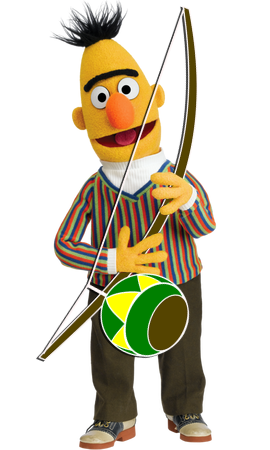
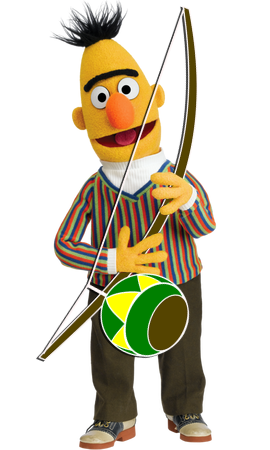

In [ ]:
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments

# Carregar o modelo pré-treinado para classificação
model = AutoModelForSequenceClassification.from_pretrained(
    "neuralmind/bert-base-portuguese-cased",
    num_labels=len(label_encoder.classes_)
)

import os

# Desativar Weights & Biases
os.environ["WANDB_DISABLED"] = "true"

# Configurar TrainingArguments 
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",  
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10
)

# Criar o Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

# Treinar o modelo
trainer.train()


In [ ]:
def predict_cluster(text):
    # Tokenizar o texto
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(model.device)
    # Obter as predições
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return label_encoder.inverse_transform([predicted_class])[0]


# Predição do Texto

In [ ]:
# Lista de novos textos para classificação
novos_textos = [
    "Software",
    "Inteligência Artificial",
    "Desenvolvimento Sustentável",
    "Análise financeira",
    "Biomassa"
]

# Função para prever os clusters para vários textos
def predict_clusters(text_list):
    predictions = {}
    for text in text_list:
        cluster = predict_cluster(text)  # Chama a função `predict_cluster` definida anteriormente
        predictions[text] = cluster
    return predictions

# Obter as previsões
clusters_previstos = predict_clusters(novos_textos)

# Exibir os resultados
for texto, cluster in clusters_previstos.items():
    print(f"O texto '{texto}' foi classificado no cluster: {cluster}")


# Conclusão

### No geral acho que ficou decente, o Bert consegue classificar os textos nos clusters, os melhores cluster são os que refletem pesquisa em comidas e biomassa, e o cluster de tecnologia e software, para melhorias eu acho que nomear as entidades na mão e tratar robustamente a base ajude a ter os cluster mais bem definidos

/tmp/ipykernel_30/2855698405.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('rocket', len(cluster_counts))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


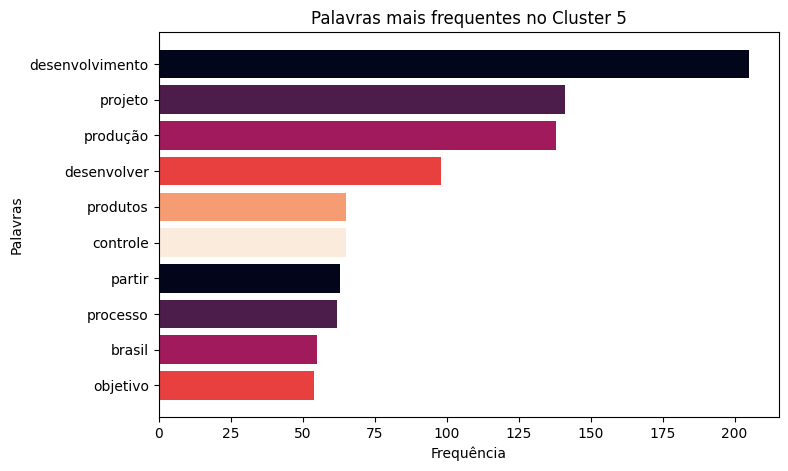

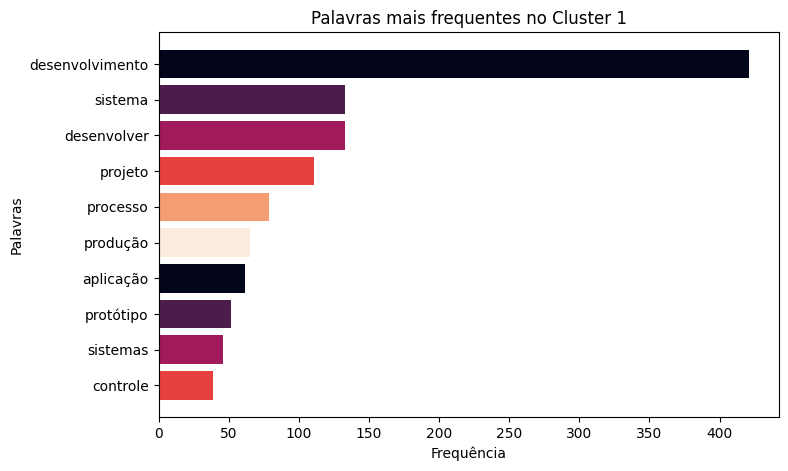

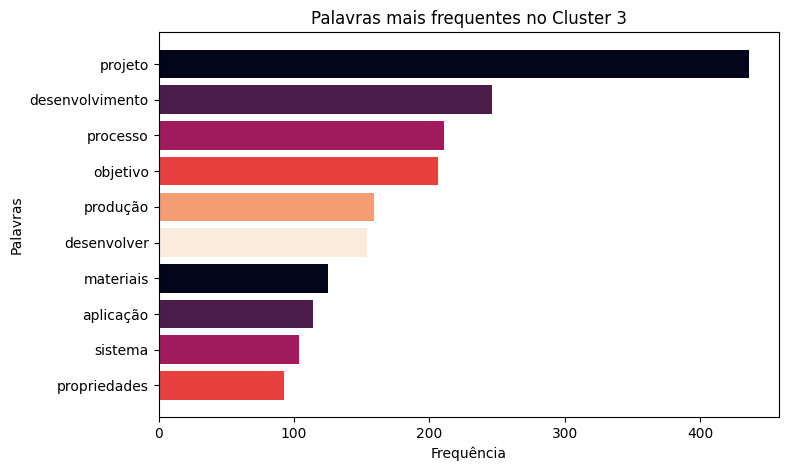

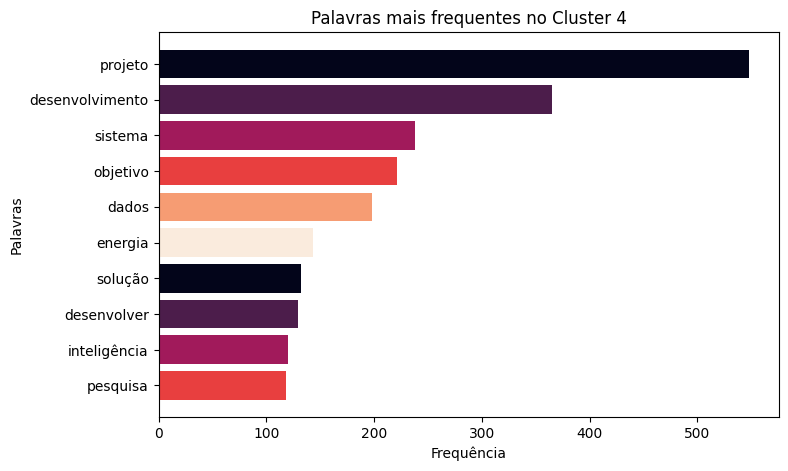

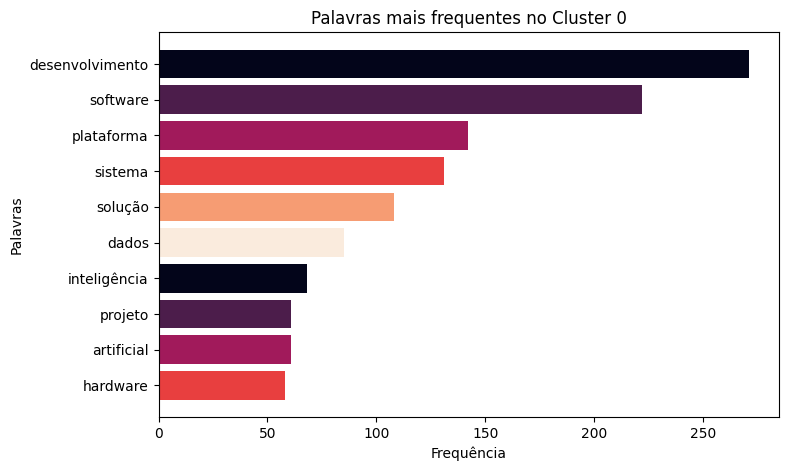

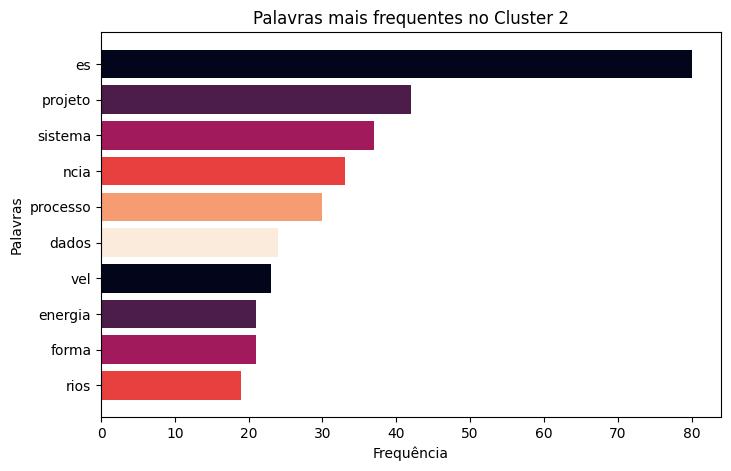

In [58]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import nltk


# Gerar cores do colormap rocket
colormap = cm.get_cmap('rocket', len(cluster_counts))
colors = [colormap(i) for i in range(len(cluster_counts))]

# Baixar stop words em português
nltk.download("stopwords")
stop_words_pt = stopwords.words("portuguese")

# Vectorizar os textos para contar palavras
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=stop_words_pt)
X_textual = vectorizer.fit_transform(data['Texto_Completo'])

# Obter as palavras mais frequentes por cluster
feature_names = vectorizer.get_feature_names_out()
clusters = data['Cluster'].unique()

for cluster_id in clusters:
    # Filtrar textos do cluster
    cluster_texts = data[data['Cluster'] == cluster_id]['Texto_Completo']
    cluster_vectorized = vectorizer.transform(cluster_texts)
    word_counts = cluster_vectorized.sum(axis=0).A1
    word_freq = pd.DataFrame({'word': feature_names, 'count': word_counts})
    word_freq = word_freq.sort_values(by='count', ascending=False).head(10)

    # Plotar as palavras mais frequentes
    plt.figure(figsize=(8, 5))
    plt.barh(word_freq['word'], word_freq['count'], color=colors)
    plt.gca().invert_yaxis()
    plt.title(f'Palavras mais frequentes no Cluster {cluster_id}')
    plt.xlabel('Frequência')
    plt.ylabel('Palavras')
    plt.show()


/tmp/ipykernel_30/2191056728.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('rocket', len(cluster_counts))


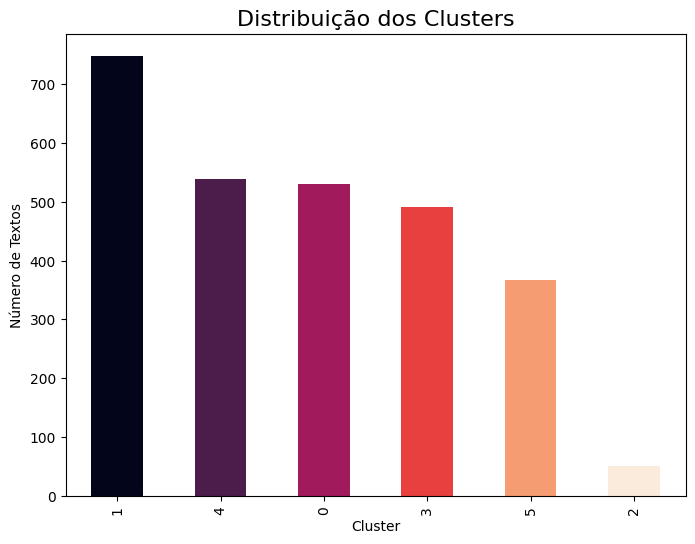

In [57]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# Contagem de textos por cluster
cluster_counts = data['Cluster'].value_counts()

colormap = cm.get_cmap('rocket', len(cluster_counts))
colors = [colormap(i) for i in range(len(cluster_counts))]
# Plotar a distribuição dos clusters
plt.figure(figsize=(8, 6))
cluster_counts.plot(kind='bar', color=colors)
plt.title("Distribuição dos Clusters", fontsize=16)
plt.xlabel("Cluster")
plt.ylabel("Número de Textos")
plt.show()


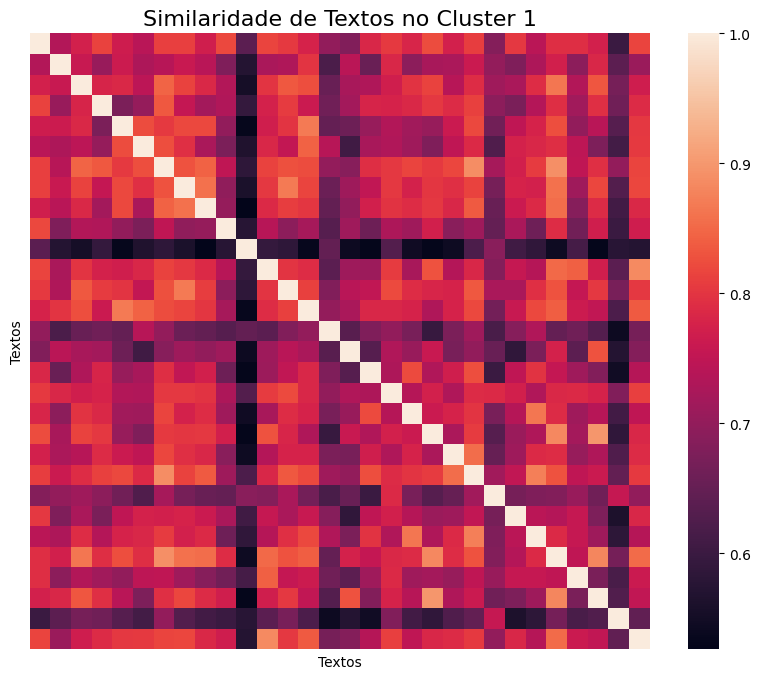

In [55]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Escolher um cluster para análise
selected_cluster = 1
cluster_embeddings = np.vstack(data[data['Cluster'] == selected_cluster]['Embedding'])

# Limitar o número de embeddings a uma amostra aleatória de 30 textos
sample_size = 30
if cluster_embeddings.shape[0] > sample_size:
    indices = np.random.choice(cluster_embeddings.shape[0], sample_size, replace=False)
    cluster_embeddings = cluster_embeddings[indices]

# Calcular similaridade coseno
similarity_matrix = cosine_similarity(cluster_embeddings)

# Plotar o mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_matrix, cmap='rocket', xticklabels=False, yticklabels=False)
plt.title(f"Similaridade de Textos no Cluster {selected_cluster}", fontsize=16)
plt.xlabel("Textos")
plt.ylabel("Textos")
plt.show()


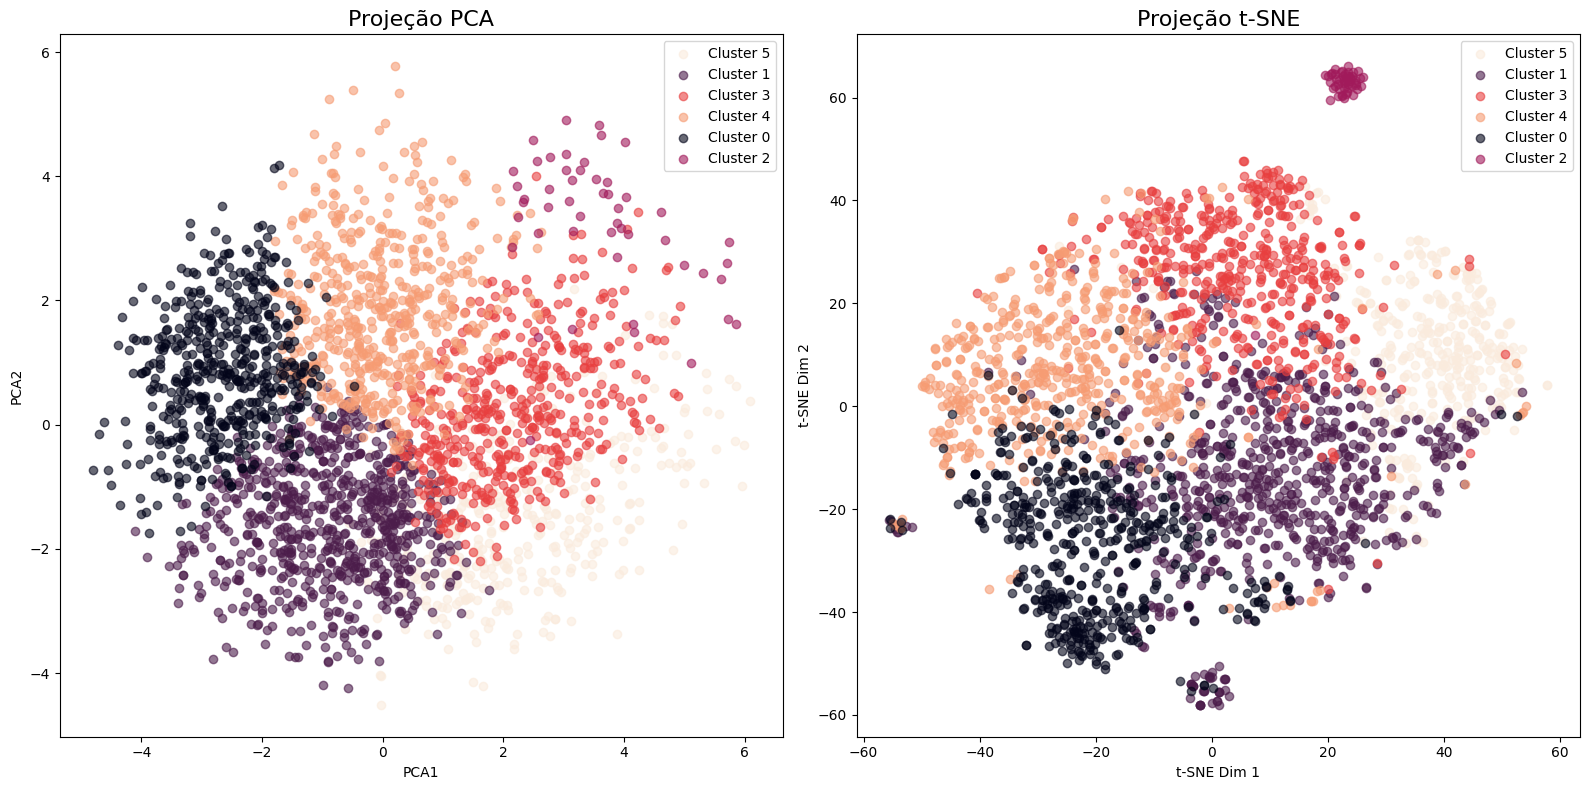

In [62]:
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")
import matplotlib.cm as cm

# Obter o colormap rocket
colormap = cm.get_cmap('rocket', len(data['Cluster'].unique()))
colors = {cluster_id: colormap(i) for i, cluster_id in enumerate(sorted(data['Cluster'].unique()))}

plt.figure(figsize=(16, 8))

# PCA
plt.subplot(1, 2, 1)
for cluster_id in data['Cluster'].unique():
    cluster_data = data[data['Cluster'] == cluster_id]
    plt.scatter(
        cluster_data['PCA1'], 
        cluster_data['PCA2'], 
        label=f'Cluster {cluster_id}', 
        color=colors[cluster_id], 
        alpha=0.6
    )
plt.title("Projeção PCA", fontsize=16)
plt.xlabel("PCA1")
plt.ylabel("PCA2")
plt.legend()

# t-SNE
plt.subplot(1, 2, 2)
for cluster_id in data['Cluster'].unique():
    cluster_data = data[data['Cluster'] == cluster_id]
    plt.scatter(
        cluster_data['TSNE1'], 
        cluster_data['TSNE2'], 
        label=f'Cluster {cluster_id}', 
        color=colors[cluster_id], 
        alpha=0.6
    )
plt.title("Projeção t-SNE", fontsize=16)
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend()

plt.tight_layout()
plt.show()


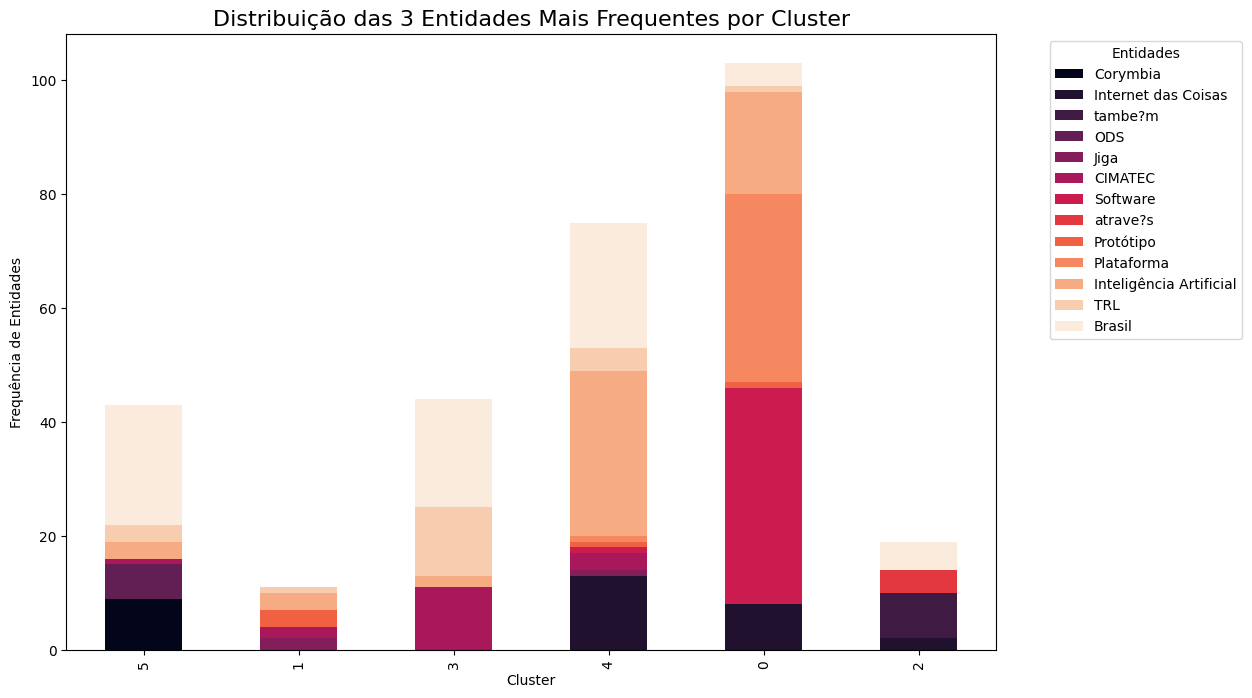

In [54]:
from collections import Counter

# Contar as entidades combinadas por cluster
entity_counts = {}
for cluster_id in data['Cluster'].unique():
    cluster_entities = data[data['Cluster'] == cluster_id]['Entidades_Combinadas'].sum()
    entity_counts[cluster_id] = Counter(cluster_entities)

# Selecionar as 3 entidades mais frequentes para cada cluster
top_entities = set()
for cluster_id, counts in entity_counts.items():
    top_entities.update([ent for ent, _ in counts.most_common(3)])

# Criar um DataFrame com apenas as entidades mais frequentes
import pandas as pd
filtered_entity_counts = {
    cluster_id: {ent: counts[ent] for ent in top_entities} for cluster_id, counts in entity_counts.items()
}
entity_df = pd.DataFrame(filtered_entity_counts).fillna(0).astype(int)

# Plotar gráfico de barras empilhadas
entity_df.T.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='rocket')
plt.title("Distribuição das 3 Entidades Mais Frequentes por Cluster", fontsize=16)
plt.xlabel("Cluster")
plt.ylabel("Frequência de Entidades")
plt.legend(title="Entidades", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()
